In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
import math
import matplotlib.pyplot as plt
import os

In [2]:
# create seed
torch.manual_seed(42)
np.random.seed(42)


In [ ]:
def load_datasets():
    train_set = pd.read_parquet(os.path.join('loaded_data', 'a_patient_triplets_processed.parquet'))
    test_set = pd.read_parquet(os.path.join('loaded_data', 'c_patient_triplets_processed.parquet'))
    return train_set, test_set

train_df, test_df = load_datasets()

X_train = torch.tensor(train_df.drop(columns=["ICUType", "In-hospital_death"]).values, dtype=torch.float32)
y_train = torch.tensor(train_df["In-hospital_death"].values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(test_df.drop(columns=["ICUType", "In-hospital_death"]).values, dtype=torch.float32)
y_test = torch.tensor(test_df["In-hospital_death"].values, dtype=torch.float32).unsqueeze(1)

feature_columns = [col for col in train_df.columns if col not in ["RecordID", "In-hospital_death", "ICUType"]]

grouped = train_df.groupby("RecordID")

def pad_to_fixed_length(tensor, length=49):
    current_length = tensor.size(0)
    if current_length < length:
        padding = torch.zeros((length - current_length, tensor.size(1)))
        return torch.cat([tensor, padding], dim=0)
    else:
        return tensor

def process_dataframe(df):
    list_of_patient_tensors = []
    patient_labels = []
    grouped = df.groupby("RecordID")
    for record_id, group in grouped:
        group_tensor = torch.tensor(group[feature_columns].values, dtype=torch.float32)
        group_tensor_fixed = pad_to_fixed_length(group_tensor, length=49)
        list_of_patient_tensors.append(group_tensor_fixed)
        # For the label, we assume that if any timestep indicates death, the patient is labeled as death (1)
        patient_labels.append(group["In-hospital_death"].max())
    sequences = torch.stack(list_of_patient_tensors, dim=0)  
    labels = torch.tensor(patient_labels, dtype=torch.float32).unsqueeze(1)
    return sequences, labels

# Process training and testing data
padded_sequences_train, labels_tensor_train = process_dataframe(train_df)
padded_sequences_test, labels_tensor_test = process_dataframe(test_df)
print(padded_sequences_train.size(), labels_tensor_train.size())

torch.Size([3997, 49, 41]) torch.Size([3997, 1])


In [4]:
def random_sample(X, y, n_samples):
    indices = np.random.choice(len(X), size=n_samples, replace=False)
    return X[indices], y[indices]

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=49):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term)[:,:pe[:, 1::2].shape[1]]
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=41, model_dim=64, num_heads=4, num_layers=2, num_classes=1, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.input_linear = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(d_model=model_dim, max_len=49)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(model_dim, num_classes)
    
    def forward(self, x):
        x = self.input_linear(x)          
        x = self.positional_encoding(x)  
        x = x.transpose(0, 1)             
        x = self.transformer_encoder(x)   
        x = x.mean(dim=0)          
        logits = self.classifier(x) 
        return logits




In [6]:
def train_model(model, train_loader, criterion, optimizer, device):
    num_epochs = 50
    epoch_losses = [] 

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        num_batches = len(train_loader)
        
        for batch_data, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()           # Zero the gradients
            logits = model(batch_data)        # Forward pass
            loss = criterion(logits, batch_labels)  # Compute loss
            loss.backward()                   # Backpropagation
            optimizer.step()                  # Update weights
            
            running_loss += loss.item()       # Accumulate batch loss
        
        avg_loss = running_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_loss:.4f}")

    # Plot the loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

    return model


In [7]:

def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_samples = 0
    all_probs = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_data, batch_labels in tqdm(dataloader, desc="Evaluating", leave=False):
            # Move data to device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            # Forward pass
            logits = model(batch_data)
            loss = criterion(logits, batch_labels)
            
            batch_size = batch_data.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            # Convert logits to probabilities and then binary predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(batch_labels.cpu())
    
    # Compute average loss over all samples
    avg_loss = total_loss / total_samples
    
    # Concatenate all predictions, probabilities, and labels
    all_probs = torch.cat(all_probs, dim=0)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Overall accuracy
    overall_accuracy = (all_preds.eq(all_labels)).float().mean().item()
    
    # Accuracy for predicting 1 (sensitivity): among all true positives, how many were predicted as 1
    pos_idx = (all_labels == 1).squeeze()
    if pos_idx.sum() > 0:
        accuracy_pos = (all_preds[pos_idx].eq(all_labels[pos_idx])).float().mean().item()
    else:
        accuracy_pos = float('nan')
    
    # Accuracy for predicting 0 (specificity): among all true negatives, how many were predicted as 0
    neg_idx = (all_labels == 0).squeeze()
    if neg_idx.sum() > 0:
        accuracy_neg = (all_preds[neg_idx].eq(all_labels[neg_idx])).float().mean().item()
    else:
        accuracy_neg = float('nan')
    
    # Compute AUROC using probabilities (make sure to flatten the arrays)
    # Compute AUPRC
    try:
        auroc = roc_auc_score(all_labels.numpy(), all_probs.numpy())
        auprc = average_precision_score(all_labels.numpy(), all_probs.numpy())
    except Exception as e:
        auroc = None
        print("Error computing AUROC:", e)
    
    return avg_loss, overall_accuracy, accuracy_pos, accuracy_neg, auroc, auprc


In [8]:
# Create TensorDatasets and DataLoaders
batch_size = 32



test_dataset = TensorDataset(padded_sequences_test, labels_tensor_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch [1/50] - Average Loss: 1.4266


Epoch [2/50] - Average Loss: 1.5223


Epoch [3/50] - Average Loss: 1.0233


Epoch [4/50] - Average Loss: 0.9859


Epoch [5/50] - Average Loss: 0.9286


Epoch [6/50] - Average Loss: 0.8325


Epoch [7/50] - Average Loss: 1.5051


Epoch [8/50] - Average Loss: 0.9297


Epoch [9/50] - Average Loss: 0.8610


Epoch [10/50] - Average Loss: 0.6095


Epoch [11/50] - Average Loss: 1.0476


Epoch [12/50] - Average Loss: 0.7635


Epoch [13/50] - Average Loss: 0.7544


Epoch [14/50] - Average Loss: 0.5950


Epoch [15/50] - Average Loss: 0.6718


Epoch [16/50] - Average Loss: 0.5008


Epoch [17/50] - Average Loss: 0.4291


Epoch [18/50] - Average Loss: 0.3922


Epoch [19/50] - Average Loss: 0.4083


Epoch [20/50] - Average Loss: 0.3386


Epoch [21/50] - Average Loss: 0.3708


Epoch [22/50] - Average Loss: 0.3132


Epoch [23/50] - Average Loss: 0.2062


Epoch [24/50] - Average Loss: 0.2795


Epoch [25/50] - Average Loss: 0.4928


Epoch [26/50] - Average Loss: 0.4027


Epoch [27/50] - Average Loss: 0.2111


Epoch [28/50] - Average Loss: 0.3526


Epoch [29/50] - Average Loss: 0.2066


Epoch [30/50] - Average Loss: 0.1704


Epoch [31/50] - Average Loss: 0.2268


Epoch [32/50] - Average Loss: 0.1308


Epoch [33/50] - Average Loss: 0.1135


Epoch [34/50] - Average Loss: 0.1087


Epoch [35/50] - Average Loss: 0.0931


Epoch [36/50] - Average Loss: 0.0817


Epoch [37/50] - Average Loss: 0.1399


Epoch [38/50] - Average Loss: 0.0691


Epoch [39/50] - Average Loss: 0.0740


Epoch [40/50] - Average Loss: 0.0507


Epoch [41/50] - Average Loss: 0.0721


Epoch [42/50] - Average Loss: 0.0521


Epoch [43/50] - Average Loss: 0.0569


Epoch [44/50] - Average Loss: 0.0405


Epoch [45/50] - Average Loss: 0.0549


Epoch [46/50] - Average Loss: 0.0413


Epoch [47/50] - Average Loss: 0.0516


Epoch [48/50] - Average Loss: 0.1247


Epoch [49/50] - Average Loss: 0.1152


Epoch [50/50] - Average Loss: 0.0633


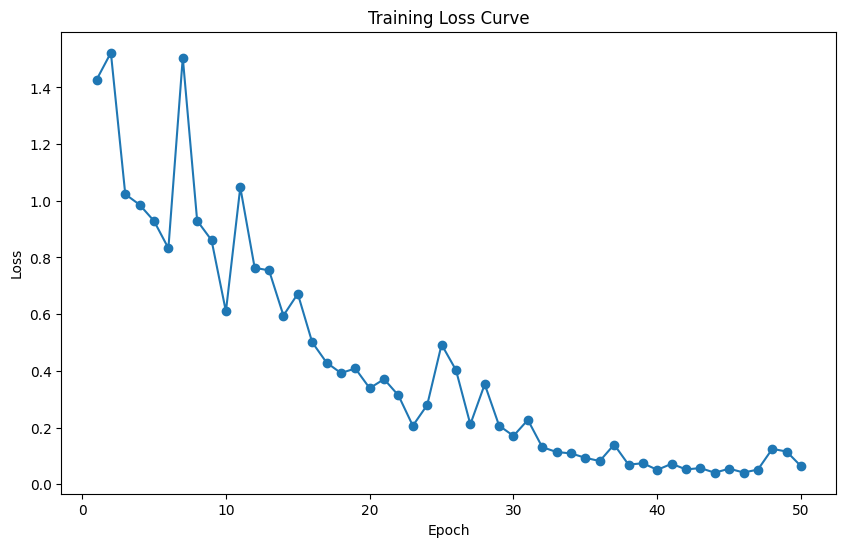

Test Loss: 3.2441
Overall Accuracy: 82.04%
Accuracy for predicting 1 (Sensitivity): 28.21%
Accuracy for predicting 0 (Specificity): 91.27%
AUROC: 0.6860
AUPRC: 0.3025


In [9]:
num_samples = 100


X_train_sample, y_train_sample = random_sample(padded_sequences_train, labels_tensor_train, num_samples)
train_dataset = TensorDataset(X_train_sample, y_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure the input dimension matches the number of features
model = TransformerClassifier(input_dim=len(feature_columns), model_dim=64, num_heads=4, num_layers=1)
model.to(device)
weights = torch.tensor([1.0, 6.5])
criterion = nn.BCEWithLogitsLoss(pos_weight = weights[1].to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_loader, criterion, optimizer, device)

test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")

Epoch [1/50] - Average Loss: 1.3272


Epoch [2/50] - Average Loss: 1.3141


Epoch [3/50] - Average Loss: 1.2242


Epoch [4/50] - Average Loss: 1.1546


Epoch [5/50] - Average Loss: 1.0925


Epoch [6/50] - Average Loss: 1.1048


Epoch [7/50] - Average Loss: 0.9954


Epoch [8/50] - Average Loss: 0.8982


Epoch [9/50] - Average Loss: 0.9145


Epoch [10/50] - Average Loss: 0.8919


Epoch [11/50] - Average Loss: 0.8162


Epoch [12/50] - Average Loss: 0.7240


Epoch [13/50] - Average Loss: 0.6984


Epoch [14/50] - Average Loss: 0.8322


Epoch [15/50] - Average Loss: 0.6196


Epoch [16/50] - Average Loss: 0.5887


Epoch [17/50] - Average Loss: 0.5376


Epoch [18/50] - Average Loss: 0.5644


Epoch [19/50] - Average Loss: 0.4440


Epoch [20/50] - Average Loss: 0.4135


Epoch [21/50] - Average Loss: 0.3948


Epoch [22/50] - Average Loss: 0.3509


Epoch [23/50] - Average Loss: 0.3326


Epoch [24/50] - Average Loss: 0.3709


Epoch [25/50] - Average Loss: 0.2997


Epoch [26/50] - Average Loss: 0.2551


Epoch [27/50] - Average Loss: 0.1735


Epoch [28/50] - Average Loss: 0.1852


Epoch [29/50] - Average Loss: 0.2070


Epoch [30/50] - Average Loss: 0.1788


Epoch [31/50] - Average Loss: 0.1688


Epoch [32/50] - Average Loss: 0.2163


Epoch [33/50] - Average Loss: 0.1926


Epoch [34/50] - Average Loss: 0.1144


Epoch [35/50] - Average Loss: 0.0929


Epoch [36/50] - Average Loss: 0.0729


Epoch [37/50] - Average Loss: 0.0598


Epoch [38/50] - Average Loss: 0.0526


Epoch [39/50] - Average Loss: 0.0463


Epoch [40/50] - Average Loss: 0.0430


Epoch [41/50] - Average Loss: 0.0338


Epoch [42/50] - Average Loss: 0.0322


Epoch [43/50] - Average Loss: 0.0325


Epoch [44/50] - Average Loss: 0.0281


Epoch [45/50] - Average Loss: 0.0306


Epoch [46/50] - Average Loss: 0.0238


Epoch [47/50] - Average Loss: 0.0206


Epoch [48/50] - Average Loss: 0.0155


Epoch [49/50] - Average Loss: 0.0165


Epoch [50/50] - Average Loss: 0.0155


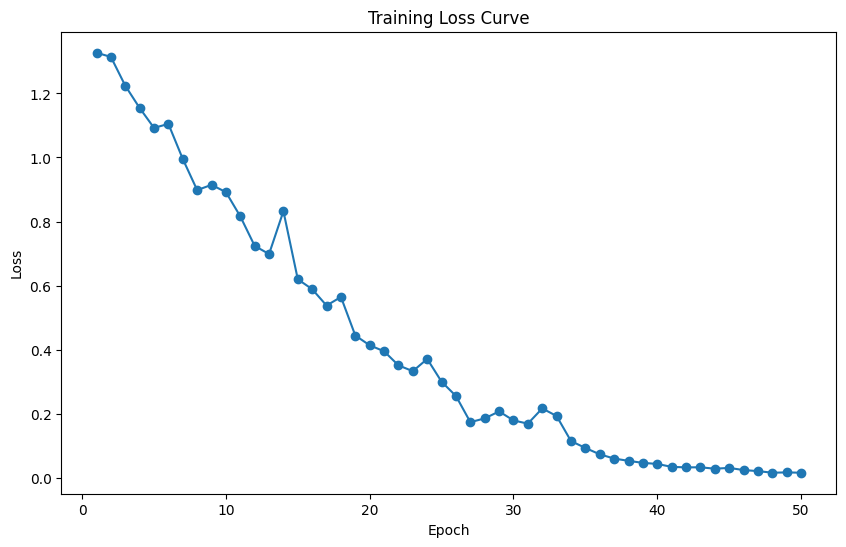

Test Loss: 3.6482
Overall Accuracy: 80.44%
Accuracy for predicting 1 (Sensitivity): 38.46%
Accuracy for predicting 0 (Specificity): 87.64%
AUROC: 0.7248
AUPRC: 0.3118


In [10]:
num_samples = 500


X_train_sample, y_train_sample = random_sample(padded_sequences_train, labels_tensor_train, num_samples)
train_dataset = TensorDataset(X_train_sample, y_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure the input dimension matches the number of features
model = TransformerClassifier(input_dim=len(feature_columns), model_dim=64, num_heads=4, num_layers=1)
model.to(device)

weights = torch.tensor([1.0, 6.5])
criterion = nn.BCEWithLogitsLoss(pos_weight = weights[1].to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

train_model(model, train_loader, criterion, optimizer, device)

test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")

Epoch [1/50] - Average Loss: 1.2393


Epoch [2/50] - Average Loss: 1.0992


Epoch [3/50] - Average Loss: 1.0010


Epoch [4/50] - Average Loss: 1.0406


Epoch [5/50] - Average Loss: 1.0197


Epoch [6/50] - Average Loss: 0.8813


Epoch [7/50] - Average Loss: 0.8522


Epoch [8/50] - Average Loss: 0.8592


Epoch [9/50] - Average Loss: 0.9179


Epoch [10/50] - Average Loss: 0.7895


Epoch [11/50] - Average Loss: 0.7592


Epoch [12/50] - Average Loss: 0.7191


Epoch [13/50] - Average Loss: 0.6904


Epoch [14/50] - Average Loss: 0.6744


Epoch [15/50] - Average Loss: 0.7098


Epoch [16/50] - Average Loss: 0.6132


Epoch [17/50] - Average Loss: 0.5519


Epoch [18/50] - Average Loss: 0.5699


Epoch [19/50] - Average Loss: 0.5533


Epoch [20/50] - Average Loss: 0.4868


Epoch [21/50] - Average Loss: 0.4101


Epoch [22/50] - Average Loss: 0.3996


Epoch [23/50] - Average Loss: 0.4312


Epoch [24/50] - Average Loss: 0.3392


Epoch [25/50] - Average Loss: 0.3593


Epoch [26/50] - Average Loss: 0.3469


Epoch [27/50] - Average Loss: 0.2615


Epoch [28/50] - Average Loss: 0.2385


Epoch [29/50] - Average Loss: 0.2321


Epoch [30/50] - Average Loss: 0.2803


Epoch [31/50] - Average Loss: 0.2233


Epoch [32/50] - Average Loss: 0.1724


Epoch [33/50] - Average Loss: 0.1460


Epoch [34/50] - Average Loss: 0.1659


Epoch [35/50] - Average Loss: 0.1043


Epoch [36/50] - Average Loss: 0.0926


Epoch [37/50] - Average Loss: 0.0854


Epoch [38/50] - Average Loss: 0.0600


Epoch [39/50] - Average Loss: 0.0498


Epoch [40/50] - Average Loss: 0.0361


Epoch [41/50] - Average Loss: 0.0219


Epoch [42/50] - Average Loss: 0.0176


Epoch [43/50] - Average Loss: 0.0135


Epoch [44/50] - Average Loss: 0.0109


Epoch [45/50] - Average Loss: 0.0088


Epoch [46/50] - Average Loss: 0.0071


Epoch [47/50] - Average Loss: 0.0069


Epoch [48/50] - Average Loss: 0.0060


Epoch [49/50] - Average Loss: 0.0052


Epoch [50/50] - Average Loss: 0.0043


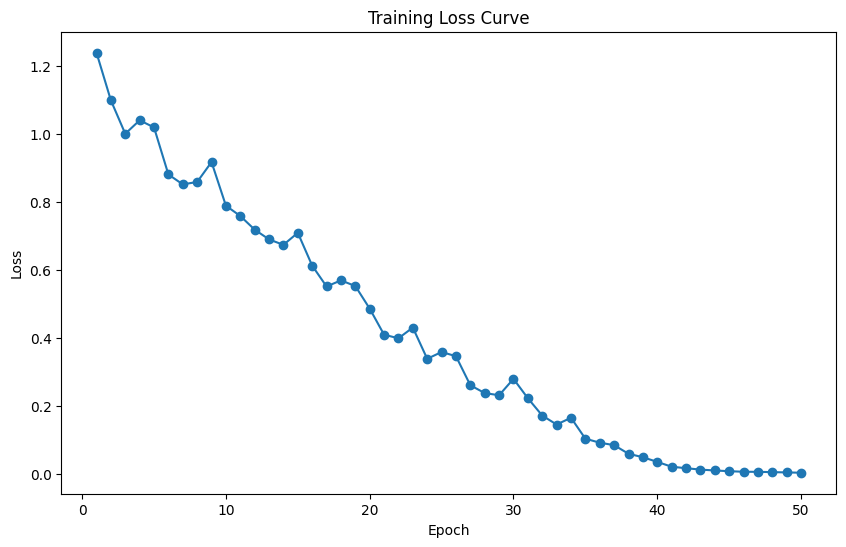

Test Loss: 4.9311
Overall Accuracy: 83.82%
Accuracy for predicting 1 (Sensitivity): 31.28%
Accuracy for predicting 0 (Specificity): 92.82%
AUROC: 0.7558
AUPRC: 0.3477


In [11]:
num_samples = 1000

X_train_sample, y_train_sample = random_sample(padded_sequences_train, labels_tensor_train, num_samples)
train_dataset = TensorDataset(X_train_sample, y_train_sample)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure the input dimension matches the number of features
model = TransformerClassifier(input_dim=len(feature_columns), model_dim=64, num_heads=4, num_layers=1)
model.to(device)

weights = torch.tensor([1.0, 6.5])
criterion = nn.BCEWithLogitsLoss(pos_weight = weights[1].to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

train_model(model, train_loader, criterion, optimizer, device)

test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")

Epoch [1/50] - Average Loss: 1.1363


Epoch [2/50] - Average Loss: 1.0001


Epoch [3/50] - Average Loss: 0.9308


Epoch [4/50] - Average Loss: 0.9016


Epoch [5/50] - Average Loss: 0.8712


Epoch [6/50] - Average Loss: 0.8366


Epoch [7/50] - Average Loss: 0.8178


Epoch [8/50] - Average Loss: 0.8135


Epoch [9/50] - Average Loss: 0.7909


Epoch [10/50] - Average Loss: 0.7371


Epoch [11/50] - Average Loss: 0.7532


Epoch [12/50] - Average Loss: 0.7135


Epoch [13/50] - Average Loss: 0.6942


Epoch [14/50] - Average Loss: 0.6858


Epoch [15/50] - Average Loss: 0.6454


Epoch [16/50] - Average Loss: 0.6208


Epoch [17/50] - Average Loss: 0.5785


Epoch [18/50] - Average Loss: 0.5700


Epoch [19/50] - Average Loss: 0.5442


Epoch [20/50] - Average Loss: 0.5311


Epoch [21/50] - Average Loss: 0.4966


Epoch [22/50] - Average Loss: 0.4751


Epoch [23/50] - Average Loss: 0.4510


Epoch [24/50] - Average Loss: 0.4082


Epoch [25/50] - Average Loss: 0.3652


Epoch [26/50] - Average Loss: 0.3818


Epoch [27/50] - Average Loss: 0.3362


Epoch [28/50] - Average Loss: 0.3313


Epoch [29/50] - Average Loss: 0.2453


Epoch [30/50] - Average Loss: 0.2380


Epoch [31/50] - Average Loss: 0.2234


Epoch [32/50] - Average Loss: 0.2812


Epoch [33/50] - Average Loss: 0.2332


Epoch [34/50] - Average Loss: 0.1744


Epoch [35/50] - Average Loss: 0.1771


Epoch [36/50] - Average Loss: 0.1071


Epoch [37/50] - Average Loss: 0.1226


Epoch [38/50] - Average Loss: 0.2357


Epoch [39/50] - Average Loss: 0.1465


Epoch [40/50] - Average Loss: 0.1776


Epoch [41/50] - Average Loss: 0.1189


Epoch [42/50] - Average Loss: 0.1242


Epoch [43/50] - Average Loss: 0.0994


Epoch [44/50] - Average Loss: 0.0915


Epoch [45/50] - Average Loss: 0.0674


Epoch [46/50] - Average Loss: 0.0447


Epoch [47/50] - Average Loss: 0.0174


Epoch [48/50] - Average Loss: 0.0097


Epoch [49/50] - Average Loss: 0.0062


Epoch [50/50] - Average Loss: 0.0045


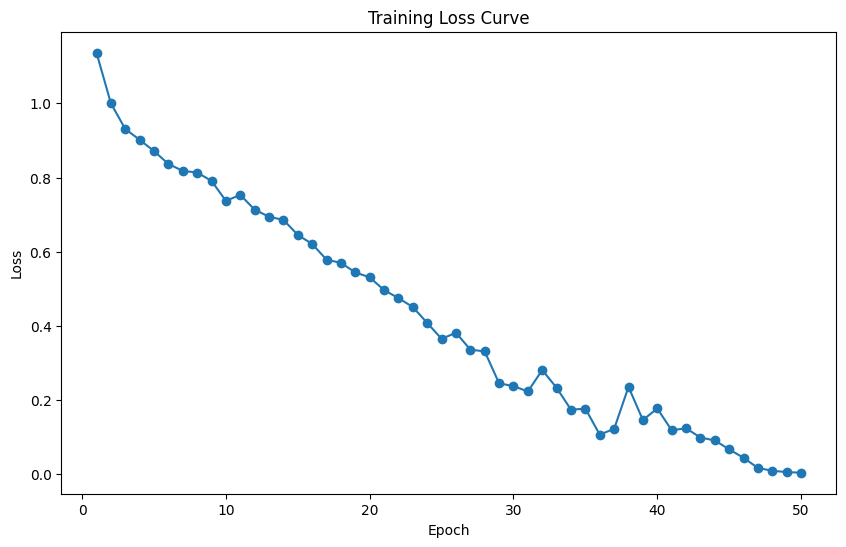

Test Loss: 6.0942
Overall Accuracy: 83.69%
Accuracy for predicting 1 (Sensitivity): 34.36%
Accuracy for predicting 0 (Specificity): 92.15%
AUROC: 0.7748
AUPRC: 0.3992


In [12]:
# All of the data

train_dataset = TensorDataset(padded_sequences_train, labels_tensor_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure the input dimension matches the number of features
model = TransformerClassifier(input_dim=len(feature_columns), model_dim=64, num_heads=4, num_layers=1)
model.to(device)

weights = torch.tensor([1.0, 6.5])
criterion = nn.BCEWithLogitsLoss(pos_weight = weights[1].to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

train_model(model, train_loader, criterion, optimizer, device)

test_loss, overall_accuracy, accuracy_pos, accuracy_neg, test_auroc, test_auprc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"Accuracy for predicting 1 (Sensitivity): {accuracy_pos*100:.2f}%")
print(f"Accuracy for predicting 0 (Specificity): {accuracy_neg*100:.2f}%")
print(f"AUROC: {test_auroc:.4f}")
print(f"AUPRC: {test_auprc:.4f}")